## ERAD 2022 Open Source Workshop

### LROSE workflow - combining NEXRAD radars, computing PID and Ecco

Ecco is a new convective/stratiform partition algorithm in LROSE. It identifies shallow, mid and deep convection.

In this case the input data is:

- MRMS - Multi-Radar Multi-Sensor reflectivity mosaic from Taiwan radar network
- GFS - global model for temperature profile

We carry out the following steps:

- Pull example data from ncar/lrose-example-data on GitHub.
- For a single radar volume, plot the composite and a N/S and E/W cross section of reflectivity.
- For a single model time, plot a N/S and W/E cross section of temperature.
- Run Ecco for a single time.
- Plot a 2-D representation (composite) of the 3-D Ecco result.


### Initialize python

In [32]:
#
# Extra packages to be added to anaconda3 standard packages for this notebook:
#
#  conda update --all
#  conda install cartopy netCDF4
#  conda install -c conda-forge arm_pyart
#

import warnings
warnings.filterwarnings('ignore')

import os
import datetime
import pytz
import math
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy import feature as cfeature
import shapely
import netCDF4 as nc
import pyart

# Set data dir in environment variable
os.environ['NEXRAD_DATA_DIR'] = '/tmp/lrose_data/nexrad'
nexradDataDir = os.environ['NEXRAD_DATA_DIR']
nexradDataDir

'/tmp/lrose_data/nexrad'

### Download data sets from GitHub

In [ ]:
# Download input data sets
#
# 1. MRMS radar mosaic grid, Taiwan domain
# 2. GFS model data for temperature profile, Taiwan domain
#
# These will be put in:
#  /tmp/lrose_data/taiwan_mrms
#

!/bin/rm -rf /tmp/lrose_data/taiwan_mrms
!mkdir -p /tmp/lrose_data/taiwan_mrms
!cd /tmp/lrose_data/taiwan_mrms; wget https://raw.githubusercontent.com/NCAR/lrose-data-examples/master/notebooks/taiwan_mrms/taiwan_gfs.example.20220608_120000.tgz
!cd /tmp/lrose_data/taiwan_mrms; wget https://raw.githubusercontent.com/NCAR/lrose-data-examples/master/notebooks/taiwan_mrms/taiwan_mrms.example.20220608_120000.tgz
!cd /tmp/lrose_data/taiwan_mrms; tar xvfz taiwan_gfs.example.20220608_120000.tgz
!cd /tmp/lrose_data/taiwan_mrms; tar xvfz taiwan_mrms.example.20220608_120000.tgz
!cd /tmp/lrose_data/taiwan_mrms; /bin/rm -f *tgz


### LROSE Parameter files

All LROSE applications have a detailed parameter file, which is read in at startup.

The parameters allow the user to control the processing in the LROSE apps.


## Convert raw nexrad files to CfRadial format

Note that we can use environment variables in the parameter files.

In [3]:
# View the param file
!cat ./params/RadxConvert.nexrad

/**********************************************************************
 * TDRP params for RadxConvert
 **********************************************************************/

//======================================================================
//
// Converts files between CfRadial and other radial formats.
//
//======================================================================
 
//======================================================================
//
// DEBUGGING.
//
//======================================================================
 
///////////// debug ///////////////////////////////////
//
// Debug option.
// If set, debug messages will be printed appropriately.
//
// Type: enum
// Options:
//     DEBUG_OFF
//     DEBUG_NORM
//     DEBUG_VERBOSE
//     DEBUG_EXTRA
//

debug = DEBUG_OFF;

///////////// instance ////////////////////////////////
//
// Program instance for process registration.
// This application registers with procmap. This is the instance used 
// 

In [4]:
# Convert raw data to cfradial for 3 NEXRAD radars

for radar_name in ['KGLD', 'KUEX', 'KDDC']:
    # Set radar in name environment variable
    os.environ['RADAR_NAME'] = radar_name
    # Run RadxConvert using param file
    !RadxConvert -params ./params/RadxConvert.nexrad -debug -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00"


Program 'RadxConvert'
Run-time 2022/08/22 03:56:35.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to 

INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad/cfradial/moments/KGLD
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad/cfradial/moments/KGLD
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad/cfradial/moments/KGLD/20210706/cfrad.20210706_222350.154_to_20210706_222826.584_KGLD_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad/cfradial/moments/KGLD/20210706/tmp.114494.1661140608.358772.tmp
  Writing fields and compressing ...
  ... writing field: DBZ
  ... writing field: VEL
  ... writing field: WIDTH
  ... writing field: ZDR
  ... writing field: PHIDP
  ... writing field: RHOHV
DEBUG - NcfRadxFile::writeToPath
  Renamed tmp path: /tmp/lrose_data/nexrad/cfradial/moments/KGLD/20210706/tmp.114494.1661140608.358772.tmp
     to final path: /tmp/lrose_data/nexrad/cfradial/moments/KGLD/20210706/cfrad.20210706_222350.154_to_20210706_222826.584_KGLD_SUR.nc
INFO: RadxFile::writeToDir
  Wrote CfRadial file to path: /tmp/l

  ... writing field: DBZ
  ... writing field: VEL
  ... writing field: WIDTH
  ... writing field: ZDR
  ... writing field: PHIDP
  ... writing field: RHOHV
DEBUG - NcfRadxFile::writeToPath
  Renamed tmp path: /tmp/lrose_data/nexrad/cfradial/moments/KUEX/20210706/tmp.114590.1661140619.881033.tmp
     to final path: /tmp/lrose_data/nexrad/cfradial/moments/KUEX/20210706/cfrad.20210706_221633.850_to_20210706_222054.868_KUEX_SUR.nc
INFO: RadxFile::writeToDir
  Wrote CfRadial file to path: /tmp/lrose_data/nexrad/cfradial/moments/KUEX/20210706/cfrad.20210706_221633.850_to_20210706_222054.868_KUEX_SUR.nc
INFO - RadxConvert::Run
  Input path: /tmp/lrose_data/nexrad/raw/KUEX/20210706/KUEX20210706_222102_V06
WARNING - NexradRadxFile::readFromPath
  Adaptation data probably not set, ignoring
  File: /tmp/lrose_data/nexrad/raw/KUEX/20210706/KUEX20210706_222102_V06
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad/cfradial/moments/KUEX
DEBUG - NcfRadxFile::writeToDir


WARNING - NexradRadxFile::readFromPath
  Adaptation data probably not set, ignoring
  File: /tmp/lrose_data/nexrad/raw/KDDC/20210706/KDDC20210706_221600_V06
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad/cfradial/moments/KDDC
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad/cfradial/moments/KDDC
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad/cfradial/moments/KDDC/20210706/cfrad.20210706_221600.999_to_20210706_222043.450_KDDC_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad/cfradial/moments/KDDC/20210706/tmp.114620.1661140633.698513.tmp
  Writing fields and compressing ...
  ... writing field: DBZ
  ... writing field: VEL
  ... writing field: WIDTH
  ... writing field: ZDR
  ... writing field: PHIDP
  ... writing field: RHOHV
DEBUG - NcfRadxFile::writeToPath
  Renamed tmp path: /tmp/lrose_data/nexrad/cfradial/moments/KDDC/20210706/tmp.114620.1661140633.698513.tmp
     to final path: /tmp/lrose_data/nexrad

## List the CfRadial files created by RadxConvert

In [5]:
# List the CfRadial files created by RadxConvert
!ls -R ${NEXRAD_DATA_DIR}/cfradial/moments

/tmp/lrose_data/nexrad/cfradial/moments:
KDDC  KGLD  KUEX

/tmp/lrose_data/nexrad/cfradial/moments/KDDC:
20210706	   _latest_data_info.buf   _latest_data_info.stat
_latest_data_info  _latest_data_info.lock  _latest_data_info.xml

/tmp/lrose_data/nexrad/cfradial/moments/KDDC/20210706:
cfrad.20210706_220000.765_to_20210706_220422.888_KDDC_SUR.nc
cfrad.20210706_220430.757_to_20210706_220912.758_KDDC_SUR.nc
cfrad.20210706_220921.610_to_20210706_221350.957_KDDC_SUR.nc
cfrad.20210706_221600.999_to_20210706_222043.450_KDDC_SUR.nc
cfrad.20210706_222051.218_to_20210706_222526.565_KDDC_SUR.nc
cfrad.20210706_222533.934_to_20210706_223025.212_KDDC_SUR.nc

/tmp/lrose_data/nexrad/cfradial/moments/KGLD:
20210706	   _latest_data_info.buf   _latest_data_info.stat
_latest_data_info  _latest_data_info.lock  _latest_data_info.xml

/tmp/lrose_data/nexrad/cfradial/moments/KGLD/20210706:
cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc
cfrad.20210706_220448.793_to_20210706_220926.383_KGLD_SUR.nc


## Plot one of the NEXRAD Goodland radar (KGLD) CfRadial files

In [6]:
# Read CfRadial file into radar object
filePathRadar = os.path.join(nexradDataDir, "cfradial/moments/KGLD/20210706/cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc")
radar_kgld = pyart.io.read_cfradial(filePathRadar)
radar_kgld.info('compact')

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: <ndarray of type: float64 and shape: (1,)>
antenna_transition: <ndarray of type: int8 and shape: (6120,)>
azimuth: <ndarray of type: float32 and shape: (6120,)>
elevation: <ndarray of type: float32 and shape: (6120,)>
fields:
	DBZ: <ndarray of type: float32 and shape: (6120, 912)>
	VEL: <ndarray of type: float32 and shape: (6120, 912)>
	WIDTH: <ndarray of type: float32 and shape: (6120, 912)>
	ZDR: <ndarray of type: float32 and shape: (6120, 912)>
	PHIDP: <ndarray of type: float32 and shape: (6120, 912)>
	RHOHV: <ndarray of type: float32 and shape: (6120, 912)>
fixed_angle: <ndarray of type: float32 and shape: (14,)>
instrument_parameters:
	follow_mode: <ndarray of type: |S1 and shape: (14, 32)>
	pulse_width: <ndarray of type: float32 and shape: (6120,)>
	prt_mode: <ndarray of type: |S1 and shape: (14, 32)>
	prt: <ndarray of type: float32 and shape: (6120,)>
	prt_ratio: <ndarray of type: float32 and shape: (6120,)>
	pol

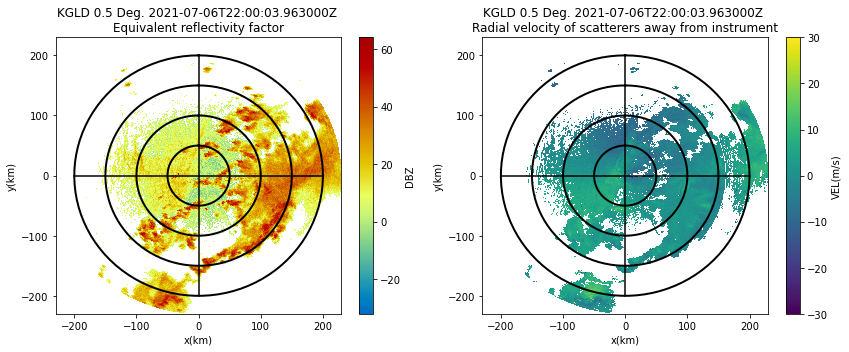

In [7]:
# Plot DBZ and VEL PPIs
displayKgld = pyart.graph.RadarDisplay(radar_kgld)
figKgld = plt.figure(1, (12, 5))
axDbz = figKgld.add_subplot(121)
displayKgld.plot_ppi('DBZ', 0, vmin=-32, vmax=64.,
                    axislabels=("x(km)", "y(km)"),
                    colorbar_label="DBZ")
displayKgld.plot_range_rings([50, 100, 150, 200])
displayKgld.plot_cross_hair(200.)
axVel = figKgld.add_subplot(122)
displayKgld.plot_ppi('VEL', 0, vmin=-30, vmax=30.,
                    axislabels=("x(km)", "y(km)"),
                    colorbar_label="VEL(m/s)")
displayKgld.plot_range_rings([50, 100, 150, 200])
displayKgld.plot_cross_hair(200.)

figKgld.tight_layout()

plt.show()

### Read in temperature field from RUC model, to provide temperature profile for PID and Ecco

In [8]:
filePathModel = os.path.join(nexradDataDir, 'mdv/ruc/20210706/20210706_230000.mdv.cf.nc')
dsModel = nc.Dataset(filePathModel)
print(dsModel)
dstemp = dsModel['TMP']
temp3D = np.array(dstemp)
fillValueTemp = dstemp._FillValue
if (len(temp3D.shape) == 4):
    temp3D = temp3D[0]

# Compute time

uTimeSecsModel = dsModel['start_time'][0]
startTimeModel = datetime.datetime.fromtimestamp(int(uTimeSecsModel))
startTimeStrModel = startTimeModel.strftime('%Y/%m/%d-%H:%M:%S UTC')
print("Start time model: ", startTimeStrModel)

# Compute Model grid limits
(nZModel, nYModel, nXModel) = temp3D.shape
lon = np.array(dsModel['x0'])
lat = np.array(dsModel['y0'])
ht = np.array(dsModel['z0'])
dLonModel = lon[1] - lon[0]
dLatModel = lat[1] - lat[0]
minLonModel = lon[0] - dLonModel / 2.0
maxLonModel = lon[-1] + dLonModel / 2.0
minLatModel = lat[0] - dLatModel / 2.0
maxLatModel = lat[-1] + dLatModel / 2.0
minHtModel = ht[0]
maxHtModel = ht[-1]
print("nZModel, nYModel, nXModel", nZModel, nYModel, nXModel)
print("minLonModel, maxLonModel: ", minLonModel, maxLonModel)
print("minLatModel, maxLatModel: ", minLatModel, maxLatModel)
print("minHt, maxHt: ", minHtModel, maxHtModel)
print("Model hts: ", ht)
del lon, lat, ht

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: Converted from NetCDF to MDV, 2022/08/21 03:33:17
  Ncf:comment: 

    source: Grib2
    title: RUC Rapid Refresh
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(139), y0(72), z0(32), nbytes_mdv_chunk_0000(174)
    variables(dimensions): float64 time(time), float64 forecast_reference_time(time), float64 forecast_period(time), float64 start_time(time), float64 stop_time(time), float32 x0(x0), float32 y0(y0), float32 z0(z0), int32 grid_mapping_0(), int32 mdv_master_header(time), int8 mdv_chunk_0000(time, nbytes_mdv_chunk_0000), float32 TMP(time, z0, y0, x0), float32 RH(time, z0, y0, x0), float32 UGRD(time, z0, y0, x0), float32 VGRD(time, z0, y0, x0), float32 VVEL(time, z0, y0, x0), float32 HGT(time, z0, y0, x0), float32 Pressure(time, z0, y0, x0)
    groups: 
Start time model:  2021/07/06-17:00:00 UTC
nZModel, nYModel, nXModel 32 72 139
minLonModel, maxLo

In [9]:
# Compute Temp N-S vertical section
nXHalfModel = int(nXModel/2)
tempVertNS = temp3D[:, :, nXHalfModel:(nXHalfModel+1)]
tempVertNS = tempVertNS.reshape(tempVertNS.shape[0], tempVertNS.shape[1])
tempVertNS[tempVertNS == fillValueTemp] = np.nan
print(tempVertNS.shape)
tempNSMax = np.amax(temp3D, (2))
tempNSMax[tempNSMax == fillValueTemp] = np.nan

# Compute Temp W-E vertical section
nYHalfModel = int(nYModel/2)
tempVertWE = temp3D[:, nYHalfModel:(nYHalfModel+1), :]
print(tempVertWE.shape)
tempVertWE = tempVertWE.reshape(tempVertWE.shape[0], tempVertWE.shape[2])
tempVertWE[tempVertWE == fillValueTemp] = np.nan
tempWEMax = np.amax(temp3D, (1))
tempWEMax[tempWEMax == fillValueTemp] = np.nan
print(tempVertWE.shape)

(32, 72)
(32, 1, 139)
(32, 139)


Text(0.5, 1.0, 'Vert slice mid W-E temp: 2021/07/06-17:00:00 UTC')

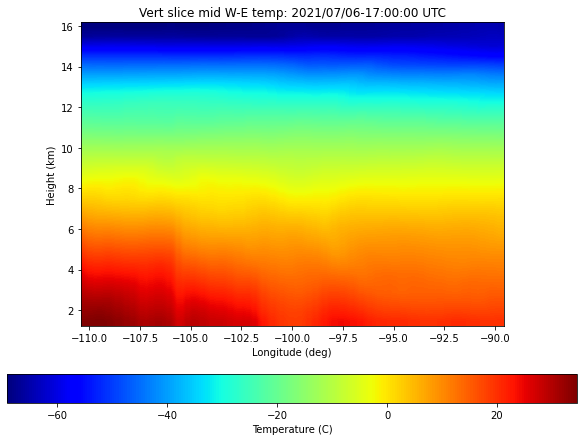

In [10]:
# Plot W-E temp vertical section
figWETemp = plt.figure(num=1, figsize=[8, 6], layout='constrained')
axWETemp = figWETemp.add_subplot(1, 1, 1, xlim = (minLonModel, maxLonModel), ylim = (minHtModel, maxHtModel))
plt.imshow(tempVertWE,
    cmap='jet',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLonModel, maxLonModel, minHtModel, maxHtModel))
axWETemp.set_aspect(1.0)
axWETemp.set_xlabel('Longitude (deg)')
axWETemp.set_ylabel('Height (km)')
plt.colorbar(label="Temperature (C)", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid W-E temp: " + startTimeStrModel)

Text(0.5, 1.0, 'Vert slice mid N-S temp: 2021/07/06-17:00:00 UTC')

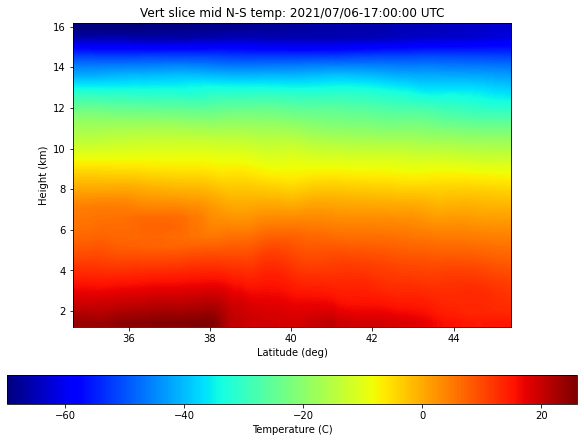

In [11]:
# Plot N-S temp vertical section
figNSTemp = plt.figure(num=1, figsize=[8, 6], layout='constrained')
axNSTemp = figNSTemp.add_subplot(1, 1, 1, xlim = (minLatModel, maxLatModel), ylim = (minHtModel, maxHtModel))
plt.imshow(tempVertNS,
    cmap='jet',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLatModel, maxLatModel, minHtModel, maxHtModel))
axNSTemp.set_aspect(0.5)
axNSTemp.set_xlabel('Latitude (deg)')
axNSTemp.set_ylabel('Height (km)')
plt.colorbar(label="Temperature (C)", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid N-S temp: " + startTimeStrModel)

## Sample RUC temperatures at radar locations, save in SPDB data base

In [12]:
# Run Mdv2SoundingSpdb to sample temperature data and store in SPDB
!Mdv2SoundingSpdb -debug -params params/Mdv2SoundingSpdb.ruc -start "2021 07 06 00 00 00" -end "2021 07 07 00 00 00"

Program 'Mdv2SoundingSpdb'
Run-time 2022/08/22 03:58:05.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as no

Ncf2MdvTrans::_shouldAddField
  -->> adding field: VGRD
Ncf2MdvTrans::_shouldAddField
  Checking variable for field data: VGRD
SUCCESS - var has X coordinate, dim: x0
SUCCESS - var has Y coordinate, dim: y0
NOTE - var has Z coordinate, dim: z0
Ncf2MdvTrans::_addOneField
  -->> adding field: VGRD
Adding data field: VGRD
             time: 2021/07/06 23:00:00
Ncf2MdvTrans::_shouldAddField
  -->> adding field: VVEL
Ncf2MdvTrans::_shouldAddField
  Checking variable for field data: VVEL
SUCCESS - var has X coordinate, dim: x0
SUCCESS - var has Y coordinate, dim: y0
NOTE - var has Z coordinate, dim: z0
Ncf2MdvTrans::_addOneField
  -->> adding field: VVEL
Adding data field: VVEL
             time: 2021/07/06 23:00:00
Ncf2MdvTrans::_shouldAddField
  -->> adding field: HGT
Ncf2MdvTrans::_shouldAddField
  Checking variable for field data: HGT
SUCCESS - var has X coordinate, dim: x0
SUCCESS - var has Y coordinate, dim: y0
NOTE - var has Z coordinate, dim: z0
Ncf2MdvTrans::_addOneField
  -->> addi

## List sounding data base

In [13]:
# List SPDB files
!ls -alR /tmp/lrose_data/nexrad/spdb

/tmp/lrose_data/nexrad/spdb:
total 0
drwxrwxr-x. 3 dixon dixon 22 Aug 21 21:23 .
drwxrwxr-x. 6 dixon dixon 56 Aug 21 21:23 ..
drwxrwxr-x. 3 dixon dixon 17 Aug 21 21:23 sounding

/tmp/lrose_data/nexrad/spdb/sounding:
total 0
drwxrwxr-x. 3 dixon dixon  17 Aug 21 21:23 .
drwxrwxr-x. 3 dixon dixon  22 Aug 21 21:23 ..
drwxrwxr-x. 2 dixon dixon 246 Aug 21 21:58 ruc

/tmp/lrose_data/nexrad/spdb/sounding/ruc:
total 140
drwxrwxr-x. 2 dixon dixon     246 Aug 21 21:58 .
drwxrwxr-x. 3 dixon dixon      17 Aug 21 21:23 ..
-rw-rw-r--. 1 dixon dixon    4704 Aug 21 21:58 20210706.data
-rw-rw-r--. 1 dixon dixon    6360 Aug 21 21:58 20210706.indx
-rw-rw-r--. 1 dixon dixon       0 Aug 21 21:23 20210707.data
-rw-rw-r--. 1 dixon dixon    6144 Aug 21 21:23 20210707.indx
-rw-rw-r--. 1 dixon dixon      54 Aug 21 21:58 _latest_data_info
-rw-rw-r--. 1 dixon dixon 1250000 Aug 21 21:58 _latest_data_info.buf
-rw-rw-r--. 1 dixon dixon       0 Aug 21 21:58 _latest_data_info.lock
-rw-rw-r--. 1 dixon dixon  100056 Aug 

## Run RadxRate on the CfRadial files

RadxRate will compute:

* KDP - specific differential phase
* KDP_SC - KDP conditioned using Z and ZDR self-consistency
* PID - NCAR Particle ID (type)
* RATE_ZH - precip rate from standard ZR relationship
* RATE_HYBRID - precip rate from NCAR hybrid estimator

RadxRate has a main parameter file, which then specifies a parameter file computing each of KDP, PID and precip rate.

The PID step requires an additional parameter file specifying the fuzzy logic thresholds.

The parameter files used here are:

* kdp_params.nexrad
* pid_params.nexrad
* pid_thresholds.nexrad
* rate_params.nexrad

In [14]:
# Run RadxRate for 3 NEXRAD radars

for radar_name in ['KGLD', 'KUEX', 'KDDC']:
    # Set radar in name environment variable
    os.environ['RADAR_NAME'] = radar_name
    # Run RadxRate using param file
    !RadxRate -params ./params/RadxRate.nexrad -debug -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00"

RadxRate::_runArchive
  Input dir: /tmp/lrose_data/nexrad/cfradial/moments/KGLD
  Start time: 2021/07/06 22:00:00
  End time: 2021/07/06 22:30:00
INFO - RadxRate::Run
  Input path: /tmp/lrose_data/nexrad/cfradial/moments/KGLD/20210706/cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc
Thread #: 0
  Loading temp profile for time: 2021/07/06 22:00:03
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad/cfradial/rate/KGLD
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad/cfradial/rate/KGLD
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad/cfradial/rate/KGLD/20210706/cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad/cfradial/rate/KGLD/20210706/tmp.114755.1661140707.237840.tmp
  Writing fields and compressing ...
  ... writing field: RATE_ZH
  ... writing field: RATE_HYBRID
  ... writing field: PID
  ... writing field: KDP
  ... writing field: DBZ
DEBUG - N

  ... writing field: RATE_ZH
  ... writing field: RATE_HYBRID
  ... writing field: PID
  ... writing field: KDP
  ... writing field: DBZ
DEBUG - NcfRadxFile::writeToPath
  Renamed tmp path: /tmp/lrose_data/nexrad/cfradial/rate/KGLD/20210706/tmp.114755.1661140724.812641.tmp
     to final path: /tmp/lrose_data/nexrad/cfradial/rate/KGLD/20210706/cfrad.20210706_222834.963_to_20210706_223310.845_KGLD_SUR.nc
INFO: RadxFile::writeToDir
  Wrote CfRadial file to path: /tmp/lrose_data/nexrad/cfradial/rate/KGLD/20210706/cfrad.20210706_222834.963_to_20210706_223310.845_KGLD_SUR.nc
RadxRate::_runArchive
  Input dir: /tmp/lrose_data/nexrad/cfradial/moments/KUEX
  Start time: 2021/07/06 22:00:00
  End time: 2021/07/06 22:30:00
INFO - RadxRate::Run
  Input path: /tmp/lrose_data/nexrad/cfradial/moments/KUEX/20210706/cfrad.20210706_220249.032_to_20210706_220715.866_KUEX_SUR.nc
Thread #: 0
  Loading temp profile for time: 2021/07/06 22:02:49
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp

RadxRate::_runArchive
  Input dir: /tmp/lrose_data/nexrad/cfradial/moments/KDDC
  Start time: 2021/07/06 22:00:00
  End time: 2021/07/06 22:30:00
INFO - RadxRate::Run
  Input path: /tmp/lrose_data/nexrad/cfradial/moments/KDDC/20210706/cfrad.20210706_220000.765_to_20210706_220422.888_KDDC_SUR.nc
Thread #: 0
  Loading temp profile for time: 2021/07/06 22:00:00
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad/cfradial/rate/KDDC
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad/cfradial/rate/KDDC
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad/cfradial/rate/KDDC/20210706/cfrad.20210706_220000.765_to_20210706_220422.888_KDDC_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad/cfradial/rate/KDDC/20210706/tmp.114850.1661140746.28760.tmp
  Writing fields and compressing ...
  ... writing field: RATE_ZH
  ... writing field: RATE_HYBRID
  ... writing field: PID
  ... writing field: KDP
  ... writing field: DBZ
DEBUG - Nc

## List files created by RadxRate

In [15]:
# List the CfRadial files created by RadxRate
!ls -R ${NEXRAD_DATA_DIR}/cfradial/rate

/tmp/lrose_data/nexrad/cfradial/rate:
KDDC  KGLD  KUEX

/tmp/lrose_data/nexrad/cfradial/rate/KDDC:
20210706	   _latest_data_info.buf   _latest_data_info.stat
_latest_data_info  _latest_data_info.lock  _latest_data_info.xml

/tmp/lrose_data/nexrad/cfradial/rate/KDDC/20210706:
cfrad.20210706_220000.765_to_20210706_220422.888_KDDC_SUR.nc
cfrad.20210706_220430.757_to_20210706_220912.758_KDDC_SUR.nc
cfrad.20210706_220921.610_to_20210706_221350.957_KDDC_SUR.nc
cfrad.20210706_221600.999_to_20210706_222043.450_KDDC_SUR.nc
cfrad.20210706_222051.218_to_20210706_222526.565_KDDC_SUR.nc
cfrad.20210706_222533.934_to_20210706_223025.212_KDDC_SUR.nc

/tmp/lrose_data/nexrad/cfradial/rate/KGLD:
20210706	   _latest_data_info.buf   _latest_data_info.stat
_latest_data_info  _latest_data_info.lock  _latest_data_info.xml

/tmp/lrose_data/nexrad/cfradial/rate/KGLD/20210706:
cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc
cfrad.20210706_220448.793_to_20210706_220926.383_KGLD_SUR.nc
cfrad.20210706_

## Plot PID and rate results for NEXRAD Goodland radar (KGLD)

In [16]:
# Read CfRadial file into radar object
filePathRate = os.path.join(nexradDataDir, "cfradial/rate/KGLD/20210706/cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc")
rate_kgld = pyart.io.read_cfradial(filePathRate)
rate_kgld.info('compact')

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: <ndarray of type: float64 and shape: (1,)>
antenna_transition: <ndarray of type: int8 and shape: (6120,)>
azimuth: <ndarray of type: float32 and shape: (6120,)>
elevation: <ndarray of type: float32 and shape: (6120,)>
fields:
	RATE_ZH: <ndarray of type: float32 and shape: (6120, 912)>
	RATE_HYBRID: <ndarray of type: float32 and shape: (6120, 912)>
	PID: <ndarray of type: float32 and shape: (6120, 912)>
	KDP: <ndarray of type: float32 and shape: (6120, 912)>
	DBZ: <ndarray of type: float32 and shape: (6120, 912)>
fixed_angle: <ndarray of type: float32 and shape: (14,)>
instrument_parameters:
	follow_mode: <ndarray of type: |S1 and shape: (14, 32)>
	pulse_width: <ndarray of type: float32 and shape: (6120,)>
	prt_mode: <ndarray of type: |S1 and shape: (14, 32)>
	prt: <ndarray of type: float32 and shape: (6120,)>
	prt_ratio: <ndarray of type: float32 and shape: (6120,)>
	polarization_mode: <ndarray of type: |S1 and shape: (

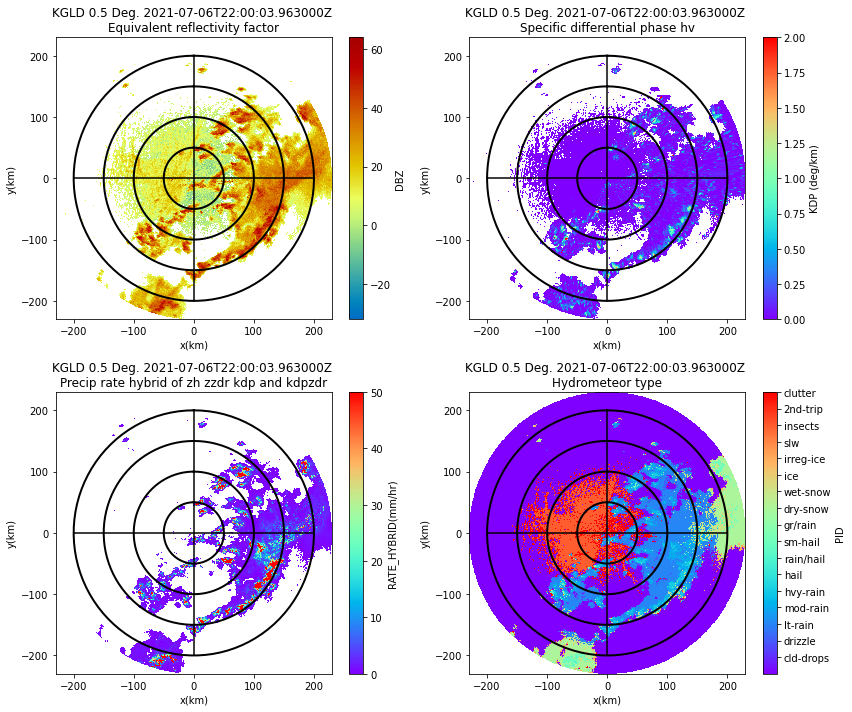

In [17]:
# Plot results of RadxRate

displayRate = pyart.graph.RadarDisplay(rate_kgld)
figRate = plt.figure(1, (12, 10))

# DBZ (input)

axDbz = figRate.add_subplot(221)
displayRate.plot_ppi('DBZ', 0, vmin=-32, vmax=64.,
                    axislabels=("x(km)", "y(km)"),
                    colorbar_label="DBZ")
displayRate.plot_range_rings([50, 100, 150, 200])
displayRate.plot_cross_hair(200.)

# KDP (computed)

axKdp = figRate.add_subplot(222)
displayRate.plot_ppi('KDP', 0, vmin=0, vmax=2.,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="KDP (deg/km)",
    cmap="rainbow")
displayRate.plot_range_rings([50, 100, 150, 200])
displayRate.plot_cross_hair(200.)

# RATE_HYBRID (computed)

axHybrid = figRate.add_subplot(223)
displayRate.plot_ppi('RATE_HYBRID', 0, vmin=0, vmax=50.,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="RATE_HYBRID(mm/hr)",
    cmap = "rainbow")
displayRate.plot_range_rings([50, 100, 150, 200])
displayRate.plot_cross_hair(200.)

# NCAR PID (computed)

axPID = figRate.add_subplot(224)
displayRate.plot_ppi('PID', 0,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="PID",
    cmap = "rainbow")
displayRate.plot_range_rings([50, 100, 150, 200])
displayRate.plot_cross_hair(200.)

pid_cbar = displayRate.cbs[3]
pid_cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
pid_cbar.set_ticklabels(['cld-drops', 'drizzle', 'lt-rain', 'mod-rain', 'hvy-rain', 'hail', 'rain/hail', 'sm-hail', 'gr/rain', 'dry-snow', 'wet-snow', 'ice', 'irreg-ice', 'slw', 'insects', '2nd-trip', 'clutter'])

figRate.tight_layout()

plt.show()

## Convert CfRadial polar files to Cartesian

In [18]:
# Run Radx2Grid for 3 NEXRAD radars

for radar_name in ['KGLD', 'KUEX', 'KDDC']:
    # Set radar in name environment variable
    os.environ['RADAR_NAME'] = radar_name
    # Run RadxRate using param file
    !Radx2Grid -params ./params/Radx2Grid.rate -debug -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00"

Program 'Radx2Grid'
Run-time 2022/08/22 03:59:51.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to co

INFO - Radx2Grid::_processFile
  Input file path: /tmp/lrose_data/nexrad/cfradial/rate/KGLD/20210706/cfrad.20210706_221420.555_to_20210706_221857.324_KGLD_SUR.nc
  Reading in file ...
TIMING, task: Cart interp - reading data, secs used: 0.381029
TIMING, task: Cart interp - before _initOutputArrays, secs used: 0.177437
TIMING, task: Cart interp - after _initOutputArrays, secs used: 0.017911
  _scanDeltaAz: 1
  _scanDeltaEl: 3.91113
  _isSector: 0
  _spansNorth: N
TIMING, task: Cart interp - before computeSearchLimits, secs used: 0.00067
  _searchRadiusEl: 5.80113
  _searchRadiusAz: 2.89
  _searchMinAz: 0
  _searchNAz: 3801
  _searchMaxDistAz: 29
TIMING, task: Computing search limits, secs used: 5.7e-05
  Filling search matrix ... 
TIMING, task: Cart interp - before fillSearchMatrix, secs used: 2.4e-05
TIMING, task: Filling search matrix, secs used: 0.091724
  Computing grid relative to radar ... 
TIMING, task: Cart interp - before _computeGridRelative, secs used: 6.1e-05
TIMING, task: C

  Adding field: PID
  Adding field: DBZ
  Adding field: range
  Adding field: Coverage
Mdv2NcfTrans::addGlobalAttributes()
Mdv2NcfTrans::addDimensions()
Mdv2NetCDF::_addTimeVariables()
Mdv2NcfTrans::addCoordinateVariables()
Mdv2NcfTrans::addFieldVariables()
adding field: RATE_HYBRID
NcfFieldData::_setChunking()
  Field: RATE_HYBRID
  nyChunk: 460
  nxChunk: 460
adding field: PID
NcfFieldData::_setChunking()
  Field: PID
  nyChunk: 460
  nxChunk: 460
adding field: DBZ
NcfFieldData::_setChunking()
  Field: DBZ
  nyChunk: 460
  nxChunk: 460
adding field: range
NcfFieldData::_setChunking()
  Field: range
  nyChunk: 460
  nxChunk: 460
adding field: Coverage
NcfFieldData::_setChunking()
  Field: Coverage
  nyChunk: 460
  nxChunk: 460
Mdv2NcfTrans::_putTimeVariables()
Mdv2NcfTrans::_putCoordinateVariables()
Mdv2NcfTrans::_putFieldDataVariables()
OutputMdv::_writeLdataInfo(): Data written to /tmp/lrose_data/nexrad/mdv/radarCart/KGLD/20210706/ncf_20210706_222834.nc
TIMING, task: Writing output 

  Adding field: DBZ
  Adding field: range
  Adding field: Coverage
Mdv2NcfTrans::addGlobalAttributes()
Mdv2NcfTrans::addDimensions()
Mdv2NetCDF::_addTimeVariables()
Mdv2NcfTrans::addCoordinateVariables()
Mdv2NcfTrans::addFieldVariables()
adding field: RATE_HYBRID
NcfFieldData::_setChunking()
  Field: RATE_HYBRID
  nyChunk: 460
  nxChunk: 460
adding field: PID
NcfFieldData::_setChunking()
  Field: PID
  nyChunk: 460
  nxChunk: 460
adding field: DBZ
NcfFieldData::_setChunking()
  Field: DBZ
  nyChunk: 460
  nxChunk: 460
adding field: range
NcfFieldData::_setChunking()
  Field: range
  nyChunk: 460
  nxChunk: 460
adding field: Coverage
NcfFieldData::_setChunking()
  Field: Coverage
  nyChunk: 460
  nxChunk: 460
Mdv2NcfTrans::_putTimeVariables()
Mdv2NcfTrans::_putCoordinateVariables()
Mdv2NcfTrans::_putFieldDataVariables()
OutputMdv::_writeLdataInfo(): Data written to /tmp/lrose_data/nexrad/mdv/radarCart/KUEX/20210706/ncf_20210706_221204.nc
TIMING, task: Writing output files, secs used: 0.

TIMING, task: Cart interp - reading data, secs used: 0.295796
TIMING, task: Cart interp - before _initOutputArrays, secs used: 8.7e-05
TIMING, task: Cart interp - after _initOutputArrays, secs used: 0.025779
  _scanDeltaAz: 0.6
  _scanDeltaEl: 2.02148
  _isSector: 0
  _spansNorth: N
TIMING, task: Cart interp - before computeSearchLimits, secs used: 0.000723
  _searchRadiusEl: 3.91148
  _searchRadiusAz: 2.49
  _searchMinAz: 0
  _searchNAz: 3801
  _searchMaxDistAz: 25
TIMING, task: Computing search limits, secs used: 8.1e-05
  Filling search matrix ... 
TIMING, task: Cart interp - before fillSearchMatrix, secs used: 1.1e-05
TIMING, task: Filling search matrix, secs used: 0.055359
  Computing grid relative to radar ... 
TIMING, task: Cart interp - before _computeGridRelative, secs used: 5.8e-05
TIMING, task: Computing grid relative to radar, secs used: 0.590125
  Interpolating ... 
TIMING, task: Cart interp - before doInterp, secs used: 3.3e-05
TIMING, task: Interpolating, secs used: 0.35

  Adding field: Coverage
Mdv2NcfTrans::addGlobalAttributes()
Mdv2NcfTrans::addDimensions()
Mdv2NetCDF::_addTimeVariables()
Mdv2NcfTrans::addCoordinateVariables()
Mdv2NcfTrans::addFieldVariables()
adding field: RATE_HYBRID
NcfFieldData::_setChunking()
  Field: RATE_HYBRID
  nyChunk: 460
  nxChunk: 460
adding field: PID
NcfFieldData::_setChunking()
  Field: PID
  nyChunk: 460
  nxChunk: 460
adding field: DBZ
NcfFieldData::_setChunking()
  Field: DBZ
  nyChunk: 460
  nxChunk: 460
adding field: range
NcfFieldData::_setChunking()
  Field: range
  nyChunk: 460
  nxChunk: 460
adding field: Coverage
NcfFieldData::_setChunking()
  Field: Coverage
  nyChunk: 460
  nxChunk: 460
Mdv2NcfTrans::_putTimeVariables()
Mdv2NcfTrans::_putCoordinateVariables()
Mdv2NcfTrans::_putFieldDataVariables()
OutputMdv::_writeLdataInfo(): Data written to /tmp/lrose_data/nexrad/mdv/radarCart/KDDC/20210706/ncf_20210706_221600.nc
TIMING, task: Writing output files, secs used: 0.7576
INFO - Radx2Grid::_processFile
  Inpu

## List files created by Radx2Grid

In [19]:
# List the Cartesian files created by Radx2Grid
!ls -R ${NEXRAD_DATA_DIR}/mdv/radarCart/K*

/tmp/lrose_data/nexrad/mdv/radarCart/KDDC:
20210706	   _latest_data_info.buf   _latest_data_info.stat
_latest_data_info  _latest_data_info.lock  _latest_data_info.xml

/tmp/lrose_data/nexrad/mdv/radarCart/KDDC/20210706:
ncf_20210706_220000.nc	ncf_20210706_220921.nc	ncf_20210706_222051.nc
ncf_20210706_220430.nc	ncf_20210706_221600.nc	ncf_20210706_222533.nc

/tmp/lrose_data/nexrad/mdv/radarCart/KGLD:
20210706	   _latest_data_info.buf   _latest_data_info.stat
_latest_data_info  _latest_data_info.lock  _latest_data_info.xml

/tmp/lrose_data/nexrad/mdv/radarCart/KGLD/20210706:
ncf_20210706_220003.nc	ncf_20210706_221420.nc	ncf_20210706_222834.nc
ncf_20210706_220448.nc	ncf_20210706_221906.nc
ncf_20210706_220935.nc	ncf_20210706_222350.nc

/tmp/lrose_data/nexrad/mdv/radarCart/KUEX:
20210706	   _latest_data_info.buf   _latest_data_info.stat
_latest_data_info  _latest_data_info.lock  _latest_data_info.xml

/tmp/lrose_data/nexrad/mdv/radarCart/KUEX/20210706:
ncf_20210706_220249.nc	ncf_20210706_221

## Merge Cartesian files into mosaic, using MdvMerge2

In [20]:
# Run MdvMerge2 to merrge the Cart data from 3 radars into a mosaic
!MdvMerge2 -params params/MdvMerge2.mosaic -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00" -debug

Program 'MdvMerge2'
Run-time 2022/08/22 04:01:06.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to co

  Read data from file: /tmp/lrose_data/nexrad/mdv/radarCart/KDDC/20210706/ncf_20210706_220921.nc
Writing merged MDV file, time 2021/07/06 22:10:00 to URL /tmp/lrose_data/nexrad/mdv/radarCart/mosaic
Wrote file: /tmp/lrose_data/nexrad/mdv/radarCart/mosaic/20210706/20210706_221000.mdv.cf.nc
  Next trigger: 2021/07/06 22:15:00
----> Trigger time: 2021/07/06 22:15:00
READ_FIRST_BEFORE
Reading data for URL: /tmp/lrose_data/nexrad/mdv/radarCart/KGLD
Mdvx read request
-----------------
  Encoding type: ENCODING_FLOAT32 (FLOAT)
  Compression type: COMPRESSION_NONE
  Scaling type: SCALING_ROUNDED
  Composite?: 0
  FillMissing?: 0
  Field names: DBZ, RATE_HYBRID, PID, range
  FieldFileHeaders?: 0
  Search mode: READ_FIRST_BEFORE
  Search time: 2021/07/06 22:15:00
  Search margin: 600 secs
  Read dir: /tmp/lrose_data/nexrad/mdv/radarCart/KGLD
  Read32BitHeaders?: false
  Read dir url: /tmp/lrose_data/nexrad/mdv/radarCart/KGLD
  Read data from file: /tmp/lrose_data/nexrad/mdv/radarCart/KGLD/2021070

  Read data from file: /tmp/lrose_data/nexrad/mdv/radarCart/KUEX/20210706/ncf_20210706_222531.nc
READ_FIRST_BEFORE
Reading data for URL: /tmp/lrose_data/nexrad/mdv/radarCart/KDDC
Mdvx read request
-----------------
  Encoding type: ENCODING_FLOAT32 (FLOAT)
  Compression type: COMPRESSION_NONE
  Scaling type: SCALING_ROUNDED
  Composite?: 0
  FillMissing?: 0
  Field names: DBZ, RATE_HYBRID, PID, range
  FieldFileHeaders?: 0
  Search mode: READ_FIRST_BEFORE
  Search time: 2021/07/06 22:30:00
  Search margin: 600 secs
  Read dir: /tmp/lrose_data/nexrad/mdv/radarCart/KDDC
  Read32BitHeaders?: false
  Read dir url: /tmp/lrose_data/nexrad/mdv/radarCart/KDDC
  Read data from file: /tmp/lrose_data/nexrad/mdv/radarCart/KDDC/20210706/ncf_20210706_222533.nc
Writing merged MDV file, time 2021/07/06 22:30:00 to URL /tmp/lrose_data/nexrad/mdv/radarCart/mosaic
Wrote file: /tmp/lrose_data/nexrad/mdv/radarCart/mosaic/20210706/20210706_223000.mdv.cf.nc
  Next trigger: 2021/07/06 22:35:00
  Done


In [21]:
# List the mosaic files created by MdvMerge2
!ls -R ${NEXRAD_DATA_DIR}/mdv/radarCart/mosaic

/tmp/lrose_data/nexrad/mdv/radarCart/mosaic:
20210706	   _latest_data_info.buf   _latest_data_info.stat
_latest_data_info  _latest_data_info.lock  _latest_data_info.xml

/tmp/lrose_data/nexrad/mdv/radarCart/mosaic/20210706:
20210706_220000.mdv.cf.nc  20210706_221500.mdv.cf.nc  20210706_223000.mdv.cf.nc
20210706_220500.mdv.cf.nc  20210706_222000.mdv.cf.nc
20210706_221000.mdv.cf.nc  20210706_222500.mdv.cf.nc


## Read in example file from radar mosaic

In [25]:
# Read in example radar mosaic for a single time

filePathMosaic = os.path.join(nexradDataDir, 'mdv/radarCart/mosaic/20210706/20210706_221500.mdv.cf.nc')
dsMosaic = nc.Dataset(filePathMosaic)
print("Radar mosaic file path: ", filePathMosaic)
print("Radar mosaic data set: ", dsMosaic)

# Compute time

uTimeSecs = dsMosaic['start_time'][0]
startTime = datetime.datetime.fromtimestamp(int(uTimeSecs))
startTimeStr = startTime.strftime('%Y/%m/%d-%H:%M:%S UTC')
print("Start time: ", startTimeStr)

# print(dsMosaic['DBZ'])
#for dim in dsMosaic.dimensions.values():
#    print(dim)
#for var in dsMosaic.variables.values():
#    print("========================================")
#    print(var)
#    print("========================================")

# create 3D dbz array with nans for missing vals

dsDbz = dsMosaic['DBZ']
dbz3D = np.array(dsDbz)
fillValue = dsDbz._FillValue
# print("fillValue: ", fillValue)

# if 4D (i.e. time is dim0) change to 3D

if (len(dbz3D.shape) == 4):
    dbz3D = dbz3D[0]

# Compute mosaic grid limits

(nZMosaic, nYMosaic, nXMosaic) = dbz3D.shape
lon = np.array(dsMosaic['x0'])
lat = np.array(dsMosaic['y0'])
ht = np.array(dsMosaic['z0'])
dLonMosaic = lon[1] - lon[0]
dLatMosaic = lat[1] - lat[0]
minLonMosaic = lon[0] - dLonMosaic / 2.0
maxLonMosaic = lon[-1] + dLonMosaic / 2.0
minLatMosaic = lat[0] - dLatMosaic / 2.0
maxLatMosaic = lat[-1] + dLatMosaic / 2.0
minHtMosaic = ht[0]
maxHtMosaic = ht[-1]

print("minLonMosaic, maxLonMosaic: ", minLonMosaic, maxLonMosaic)
print("minLatMosaic, maxLatMosaic: ", minLatMosaic, maxLatMosaic)
print("minHt, maxHt: ", minHtMosaic, maxHtMosaic)
print("hts: ", ht)
del lon, lat, ht

# Compute column-max reflectivity

dbzPlaneMax = np.amax(dbz3D, (0))
dbzPlaneMax[dbzPlaneMax == fillValue] = np.nan

print("Shape of composite DBZ grid: ", dbzPlaneMax.shape)
#print(dbzPlaneMax[dbzPlaneMax != np.nan])
#print(np.min(dbzPlaneMax[dbzPlaneMax != np.nan]))
#print(np.max(dbzPlaneMax))


Radar mosaic file path:  /tmp/lrose_data/nexrad/mdv/radarCart/mosaic/20210706/20210706_221500.mdv.cf.nc
Radar mosaic data set:  <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: Data merged from following files:
  /tmp/lrose_data/nexrad/mdv/radarCart/KGLD/20210706/ncf_20210706_221420.nc
  /tmp/lrose_data/nexrad/mdv/radarCart/KUEX/20210706/ncf_20210706_221204.nc
  /tmp/lrose_data/nexrad/mdv/radarCart/KDDC/20210706/ncf_20210706_220921.nc

    source: NEXRAD radars
    title: 3D RADAR MOSAIC
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(900), y0(700), z0(31)
    variables(dimensions): float64 time(time), float64 start_time(time), float64 stop_time(time), float64 time_bounds(time, bounds), float32 x0(x0), float32 y0(y0), float32 z0(z0), int32 grid_mapping_0(), int32 mdv_master_header(time), int16 DBZ(time, z0, y0, x0), int16 RATE_HYBRID(time, z0, y0, x0), int16 PID(time, z0, y0, x0), int16 range(time, z0

### Create map for Cartesian grid plotting

In [34]:
# Create map for plotting lat/lon grids
def new_map(fig):
    
    ## Create projection centered on data
    proj = ccrs.PlateCarree()

    ## New axes with the specified projection:
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    
    ## Set extent the same as radar mosaic
    ax.set_extent([minLonMosaic, maxLonMosaic, minLatMosaic, maxLatMosaic])

    ## Add grid lines & labels:
    gl = ax.gridlines( crs=ccrs.PlateCarree()
                     , draw_labels=True
                     , linewidth=1
                     , color='lightgray'
                     , alpha=0.5, linestyle='--'
                     ) 
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'weight': 'bold'}
    
    return ax

### Plot column-max reflectivity in plan view, and a N/S and W/E cross section of reflectivity

Text(0.5, 1.0, 'Radar mosaic column-max DBZ: 2021/07/06-16:09:21 UTC')

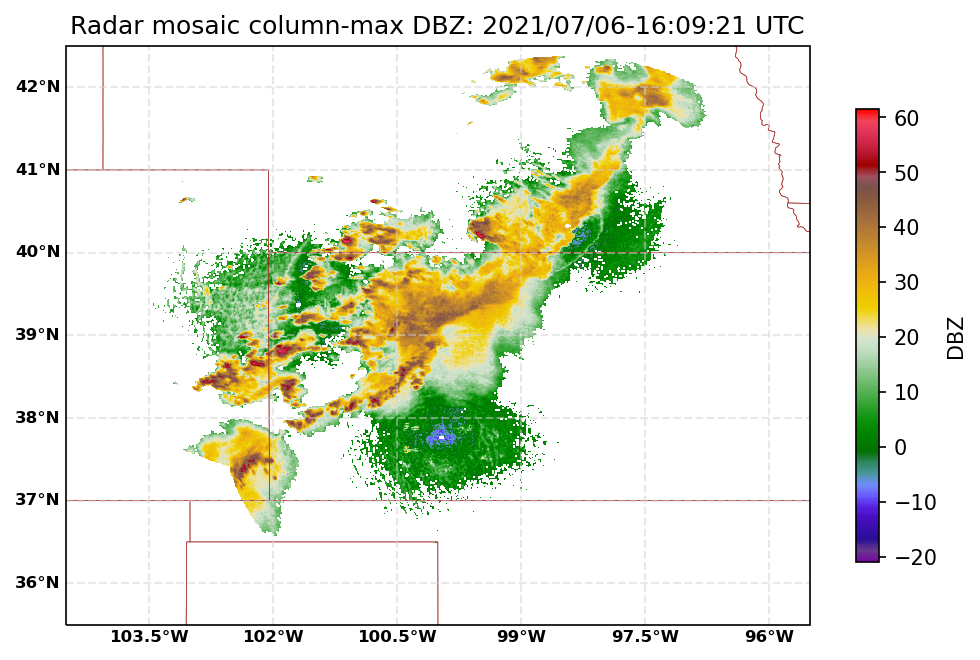

In [35]:
# Plot column-max reflectivity
fig1 = plt.figure(figsize=(8, 8), dpi=150)
ax1 = new_map(fig1)
plt.imshow(dbzPlaneMax,
            cmap='pyart_Carbone42',
            interpolation = 'bilinear',
            origin = 'lower',
            extent = (minLonMosaic, maxLonMosaic, minLatMosaic, maxLatMosaic))
ax1.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
ax1.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='brown')
#ax1.coastlines('10m', 'darkgray', linewidth=1, zorder=0)
plt.colorbar(label="DBZ", orientation="vertical", shrink=0.5)
plt.title("Radar mosaic column-max DBZ: " + startTimeStr)

In [36]:
# Compute W-E DBZ vertical section
nYHalfMosaic = int(nYMosaic/2)
dbzVertWE = dbz3D[:, nYHalfMosaic:(nYHalfMosaic+1), :]
print(dbzVertWE.shape)
dbzVertWE = dbzVertWE.reshape(dbzVertWE.shape[0], dbzVertWE.shape[2])
print(dbzVertWE.shape)
dbzVertWE[dbzVertWE == fillValue] = np.nan
dbzWEMax = np.amax(dbz3D, (1))
dbzWEMax[dbzWEMax == fillValue] = np.nan

# Compute DBZ N-S vertical section
nXHalfMosaic = int(nXMosaic/2)
dbzVertNS = dbz3D[:, :, nXHalfMosaic:(nXHalfMosaic+1)]
dbzVertNS = dbzVertNS.reshape(dbzVertNS.shape[0], dbzVertNS.shape[1])
dbzVertNS[dbzVertNS == fillValue] = np.nan
print(dbzVertNS.shape)
dbzNSMax = np.amax(dbz3D, (2))
dbzNSMax[dbzNSMax == fillValue] = np.nan


(31, 1, 900)
(31, 900)
(31, 700)


Text(0.5, 1.0, 'Vert slice mid W-E DBZ: 2021/07/06-16:09:21 UTC')

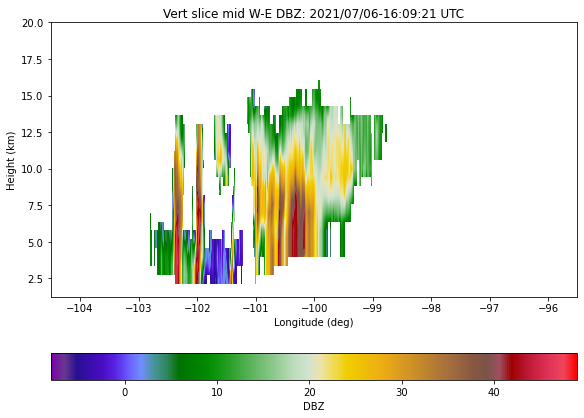

In [37]:
# Plot W-E DBZ vertical section
fig2 = plt.figure(num=2, figsize=[8, 8], layout='constrained')
ax2 = fig2.add_subplot(1, 1, 1, xlim = (minLonMosaic, maxLonMosaic), ylim = (minHtMosaic, maxHtMosaic))
plt.imshow(dbzVertWE,
    cmap='pyart_Carbone42',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLonMosaic, maxLonMosaic, minHtMosaic, maxHtMosaic))
ax2.set_aspect(0.25)
ax2.set_xlabel('Longitude (deg)')
ax2.set_ylabel('Height (km)')
plt.colorbar(label="DBZ", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid W-E DBZ: " + startTimeStr)

(31, 700)


Text(0.5, 1.0, 'Vert slice mid NS DBZ: 2021/07/06-16:09:21 UTC')

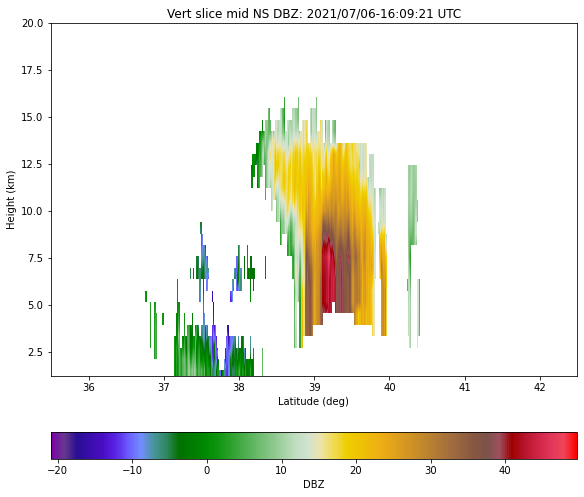

In [38]:
# Plot DBZ N-S vertical section
print(dbzVertNS.shape)
fig3 = plt.figure(num=3, figsize=[8, 8], layout='constrained')
ax3 = fig3.add_subplot(1, 1, 1, xlim = (minLatMosaic, maxLatMosaic), ylim = (minHtMosaic, maxHtMosaic))
plt.imshow(dbzVertNS,
    cmap='pyart_Carbone42',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLatMosaic, maxLatMosaic, minHtMosaic, maxHtMosaic))
ax3.set_aspect(0.25)
ax3.set_xlabel('Latitude (deg)')
ax3.set_ylabel('Height (km)')
plt.colorbar(label="DBZ", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid NS DBZ: " + startTimeStr)

### View the Ecco parameter file

The paths of the input files, and the output results file, are specified in the parameters.

Also included are all of the parameters used to control the algorithm.


In [ ]:
# View the param file
!cat ./params/Ecco.nexrad_mosaic

### Run Ecco

We run Ecco by specifying the parameter file, and the start and end times for the analysis.

In [39]:
# Run Ecco using param file
!Ecco -params ./params/Ecco.nexrad_mosaic -debug -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00"

Program 'Ecco'
Run-time 2022/08/22 04:21:08.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to confuse

### Read in Ecco results for a selected time

In [41]:
# Read in ecco results for a selected time
filePathEcco = os.path.join(nexradDataDir, 'mdv/ecco/mosaic/20210706/20210706_221500.mdv.cf.nc')
dsEcco = nc.Dataset(filePathEcco)
print(dsEcco)

# create 3D ecco type array with nans for missing vals

eccoField = dsEcco['EchoType3D']
ecco3D = np.array(eccoField)
fillValue = eccoField._FillValue
print("fillValue: ", fillValue)
print("ecco3D.shape: ", ecco3D.shape)

# if 4D (i.e. time is dim0) change to 3D
if (len(ecco3D.shape) == 4):
    ecco3D = ecco3D[0]

# Compute Ecco grid limits
(nZEcco, nYEcco, nXEcco) = ecco3D.shape
lon = np.array(dsEcco['x0'])
lat = np.array(dsEcco['y0'])
ht = np.array(dsEcco['z0'])
dLonEcco = lon[1] - lon[0]
dLatEcco = lat[1] - lat[0]
minLonEcco = lon[0] - dLonEcco / 2.0
maxLonEcco = lon[-1] + dLonEcco / 2.0
minLatEcco = lat[0] - dLatEcco / 2.0
maxLatEcco = lat[-1] + dLatEcco / 2.0
minHtEcco = ht[0]
maxHtEcco = ht[-1]
print("minLonEcco, maxLonEcco: ", minLonEcco, maxLonEcco)
print("minLatEcco, maxLatEcco: ", minLatEcco, maxLatEcco)
print("minHt, maxHt: ", minHtEcco, maxHtEcco)
print("ht: ", ht)
del lon, lat, ht

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: Converted from NetCDF to MDV, 2022/08/22 04:21:20
  Ncf:history: Data merged from following files:
  /tmp/lrose_data/nexrad/mdv/radarCart/KGLD/20210706/ncf_20210706_221420.nc
  /tmp/lrose_data/nexrad/mdv/radarCart/KUEX/20210706/ncf_20210706_221204.nc
  /tmp/lrose_data/nexrad/mdv/radarCart/KDDC/20210706/ncf_20210706_220921.nc

  Ncf:comment: 
 : Stratfinder used to identify stratiform regions
    source: NEXRAD radars
    title: 3D RADAR MOSAIC
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(900), y0(700), x1(139), y1(72), z0(1), z1(32), z2(31), nbytes_mdv_chunk_0000(464)
    variables(dimensions): float64 time(time), float64 start_time(time), float64 stop_time(time), float64 time_bounds(time, bounds), float32 x0(x0), float32 y0(y0), float32 x1(x1), float32 y1(y1), float32 z0(z0), float32 z1(z1), float32 z2(z2), int32 grid_mapping_0(), int32 grid_mapping

### Compute the column-max of the Ecco 3-D results 

In [42]:
# Compute column-max echo type
eccoPlaneMax = np.amax(ecco3D, (0))
eccoPlaneMax[eccoPlaneMax == fillValue] = np.nan
print(eccoPlaneMax.shape)
print(eccoPlaneMax[eccoPlaneMax != np.nan])
print(np.min(eccoPlaneMax[eccoPlaneMax != np.nan]))
print(np.max(eccoPlaneMax))

(700, 900)
[nan nan nan ... nan nan nan]
nan
nan


### Plot the column max of the Ecco results

Text(0.5, 1.0, 'Column max of Ecco results for radar mosaic: 2021/07/06-16:09:21 UTC')

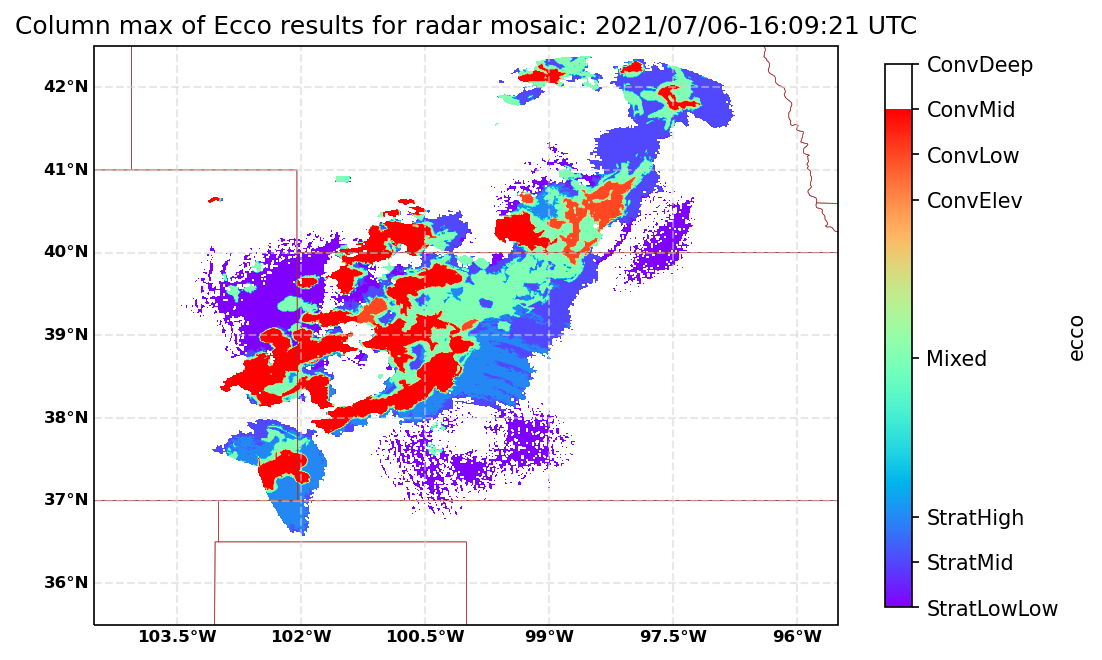

In [50]:
# Plot column-max ecco
fig6 = plt.figure(figsize=(8, 8), dpi=150)
ax6 = new_map(fig6)
plt.imshow(eccoPlaneMax,
            cmap='rainbow',
            interpolation = 'bilinear',
            origin = 'lower',
            extent = (minLonEcco, maxLonEcco, minLatEcco, maxLatEcco))
ax6.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
ax6.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='brown')
cbar = plt.colorbar(label="ecco", cax=None, orientation="vertical", shrink=0.6)
cbar.set_ticks([14,16,18,25,32,34,36,38])
cbar.set_ticklabels(['StratLowLow', 'StratMid', 'StratHigh', 'Mixed', 'ConvElev', 'ConvLow', 'ConvMid', 'ConvDeep'])

plt.title("Column max of Ecco results for radar mosaic: " + startTimeStr)
